In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.interpolate import interp1d
import multiprocessing
from multiprocessing import Pool

In [3]:
Lv = 2500000
Cp = 1004
g0 = 9.80665

In [4]:
class TaiESM():
    def __init__(self, data):
        self.data = xr.open_dataset(data)
    
    def getVar(self, var):
        if type(var) == str:
            return self.data[var].to_numpy()
        elif type(var) == list or type(var) == numpy.ndarray:
            retVal = []
            for i in range(len(var)):
                retVal.append(self.data[var[i]].to_numpy())
            return retVal

In [5]:
u850avg, v850avg = [], []
Tsavg = []
MSE_prof = []

for day in range(1, 7, 1):
    data_name = f"./hist/f09.B2000.b08209006.week3hw.cam.h0.0671-01-0{str(day)}-00000.nc"
    model = TaiESM(data_name)

    lon, lat, lev = model.getVar(['lon', 'lat', 'lev'])
    PS, P0, hyam, hybm = model.getVar(['PS', 'P0', 'hyam', 'hybm'])
    PS = PS[0]

    u850, v850, qv, Z3, T = model.getVar(['U850', 'V850', 'Q', 'Z3', 'T'])
    u850, v850, qv, Z3, T = u850[0], v850[0], qv[0], Z3[0], T[0]

    lon2, lat2 = np.meshgrid(lon, lat)

    PS_tile = np.tile(PS, (30, 1, 1))
    hybm_tile = np.tile(hybm, (192, 288, 1)).swapaxes(0, 2).swapaxes(1, 2)
    PRS_lev = np.tile(P0*hyam, (192, 288, 1)).swapaxes(0, 2).swapaxes(1, 2) + PS_tile * hybm_tile
    
    
    u850avg.append(u850)
    v850avg.append(v850)
    
    weights = np.cos(np.deg2rad(lat2))
    weights /= weights.mean()
    Ts = (xr.open_dataset(data_name)['TS'][0].to_numpy() * weights).mean()
    
    Tsavg.append(np.mean(Ts))
    
    
    MSE_prof.append(np.mean(np.mean(Cp * T + Z3 * g0 + Lv * qv, axis=1), axis=1))
    
u850avg = np.mean(u850avg, axis=0)
v850avg = np.mean(v850avg, axis=0)

In [13]:
P_ip = np.array([100000, 98000, 96000, 94000, 90000, 85000, 80000, 
          75000, 70000, 65000, 60000, 50000, 40000, 
          35000, 30000, 25000, 20000, 15000, 14000, 13000, 12000, 11000, 
          10000, 8000, 6000, 3000, 2000, 1000, 500])
def Var_IP_func(day):
    print(day)
    data_name = f"./hist/f09.B2000.b08209006.week3hw.cam.h0.0671-01-0{str(day)}-00000.nc"
    model = TaiESM(data_name)

    lon, lat, lev = model.getVar(['lon', 'lat', 'lev'])
    PS, P0, hyam, hybm = model.getVar(['PS', 'P0', 'hyam', 'hybm'])
    PS = PS[0]

    u850, v850, qv, Z3, T = model.getVar(['U850', 'V850', 'Q', 'Z3', 'T'])
    u850, v850, qv, Z3, T = u850[0], v850[0], qv[0], Z3[0], T[0]

    lon2, lat2 = np.meshgrid(lon, lat)

    PS_tile = np.tile(PS, (30, 1, 1))
    hybm_tile = np.tile(hybm, (192, 288, 1)).swapaxes(0, 2).swapaxes(1, 2)
    PRS_lev = np.tile(P0*hyam, (192, 288, 1)).swapaxes(0, 2).swapaxes(1, 2) + PS_tile * hybm_tile


    T_ip = -np.ones([len(P_ip), 192, 288])
    Z3_ip = -np.ones([len(P_ip), 192, 288])
    qv_ip = -np.ones([len(P_ip), 192, 288])
    for y in range(192):
        for x in range(288):
            T_ip_fuc = interp1d(PRS_lev[:, y, x], T[:, y, x])
            Z3_ip_fuc = interp1d(PRS_lev[:, y, x], Z3[:, y, x])
            qv_ip_fuc = interp1d(PRS_lev[:, y, x], qv[:, y, x])

            for z in range(len(T_ip)):
                try:
                    T_ip[z, y, x] = T_ip_fuc(P_ip[z])
                    Z3_ip[z, y, x] = Z3_ip_fuc(P_ip[z])
                    qv_ip[z, y, x] = qv_ip_fuc(P_ip[z])
                except:
                    continue

    T_ip = np.where(T_ip == -1, np.nan, T_ip)
    Z3_ip = np.where(Z3_ip == -1, np.nan, Z3_ip)
    qv_ip = np.where(qv_ip == -1, np.nan, qv_ip)
    
    np.save(f"T_ip_{day}.npy", T_ip)
    np.save(f"Z3_ip_{day}.npy", Z3_ip)
    np.save(f"qv_ip_{day}.npy", qv_ip)

In [ ]:
nProc = int(multiprocessing.cpu_count())-1
with Pool(nProc) as p:
    results = [p.apply_async(Var_IP_func, (day, )) for day in range(1, 7, 1)]
    final = [result.get() for result in results]

125346







In [5]:
T_ip_all, Z3_ip_all, qv_ip_all = [], [], []
for day in range(1, 7):
    T_ip_all.append(np.load(f"T_ip_{day}.npy"))
    Z3_ip_all.append(np.load(f"Z3_ip_{day}.npy"))                     
    qv_ip_all.append(np.load(f"qv_ip_{day}.npy"))
    
T_ip_all = np.nanmean(np.asarray(T_ip_all), axis=0)
Z3_ip_all = np.nanmean(np.asarray(Z3_ip_all), axis=0)
qv_ip_all = np.nanmean(np.asarray(qv_ip_all), axis=0)

/tmp/ipykernel_3696519/2643763670.py:7: RuntimeWarning: Mean of empty slice
  T_ip_all = np.nanmean(np.asarray(T_ip_all), axis=0)
/tmp/ipykernel_3696519/2643763670.py:8: RuntimeWarning: Mean of empty slice
  Z3_ip_all = np.nanmean(np.asarray(Z3_ip_all), axis=0)
/tmp/ipykernel_3696519/2643763670.py:9: RuntimeWarning: Mean of empty slice
  qv_ip_all = np.nanmean(np.asarray(qv_ip_all), axis=0)


In [6]:
MSE_all = Cp * T_ip_all + g0 * Z3_ip_all + Lv * qv_ip_all

In [10]:
day = 1
data_name = f"./hist/f09.B2000.b08209006.week3hw.cam.h0.0671-01-0{str(day)}-00000.nc"
model = TaiESM(data_name)

lon, lat = model.getVar(['lon', 'lat'])
lon2, lat2 = np.meshgrid(lon, lat)
weights = np.cos(np.deg2rad(lat2))
MSE_mean = []
for lev in range(29):
    weights_filter = np.where(np.isnan(MSE_all[lev]), np.nan, weights)
    weights_filter = weights_filter / np.nanmean(weights_filter)
    MSE_mean.append(np.nanmean(MSE_all[lev] * weights_filter))


In [11]:
skip = 4
wind_color = "#5c5959"
wind = 20
DPI = 300

/home/Aaron/miniconda3/envs/python3.8/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/Aaron/miniconda3/envs/python3.8/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


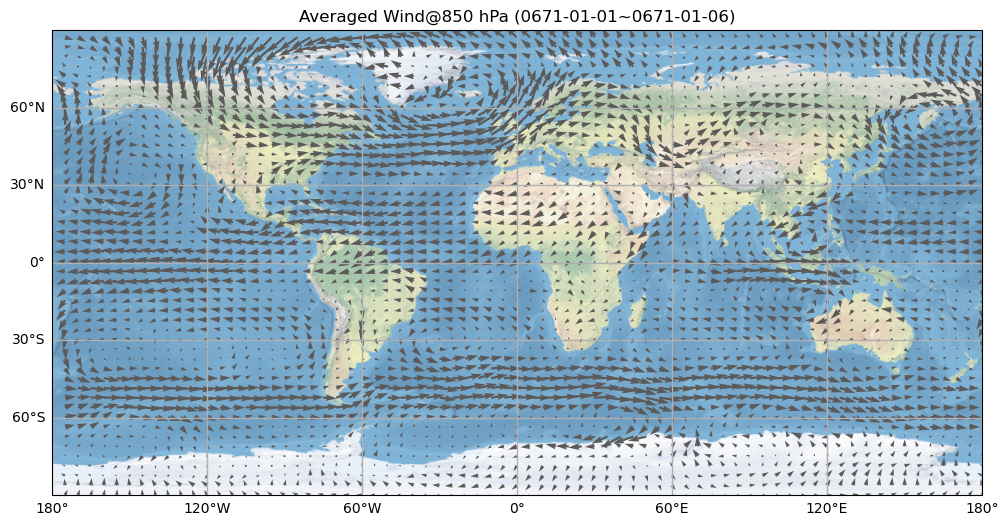

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
Q = ax.quiver(lon2[::skip, ::skip], lat2[::skip, ::skip], u850avg[::skip, ::skip], v850avg[::skip, ::skip], angles='xy', units="width", color=wind_color)
ax.quiverkey(Q, 0.85, 0.87, wind, f"{wind}" + r'm/s', labelpos='E', coordinates='figure')  

ax.stock_img()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth = 1)
gl.xlabels_top = False
gl.ylabels_right = False

plt.title("Averaged Wind@850 hPa (0671-01-01~0671-01-06)")
plt.savefig("./averaged_wind.png", dpi=DPI)
plt.show()

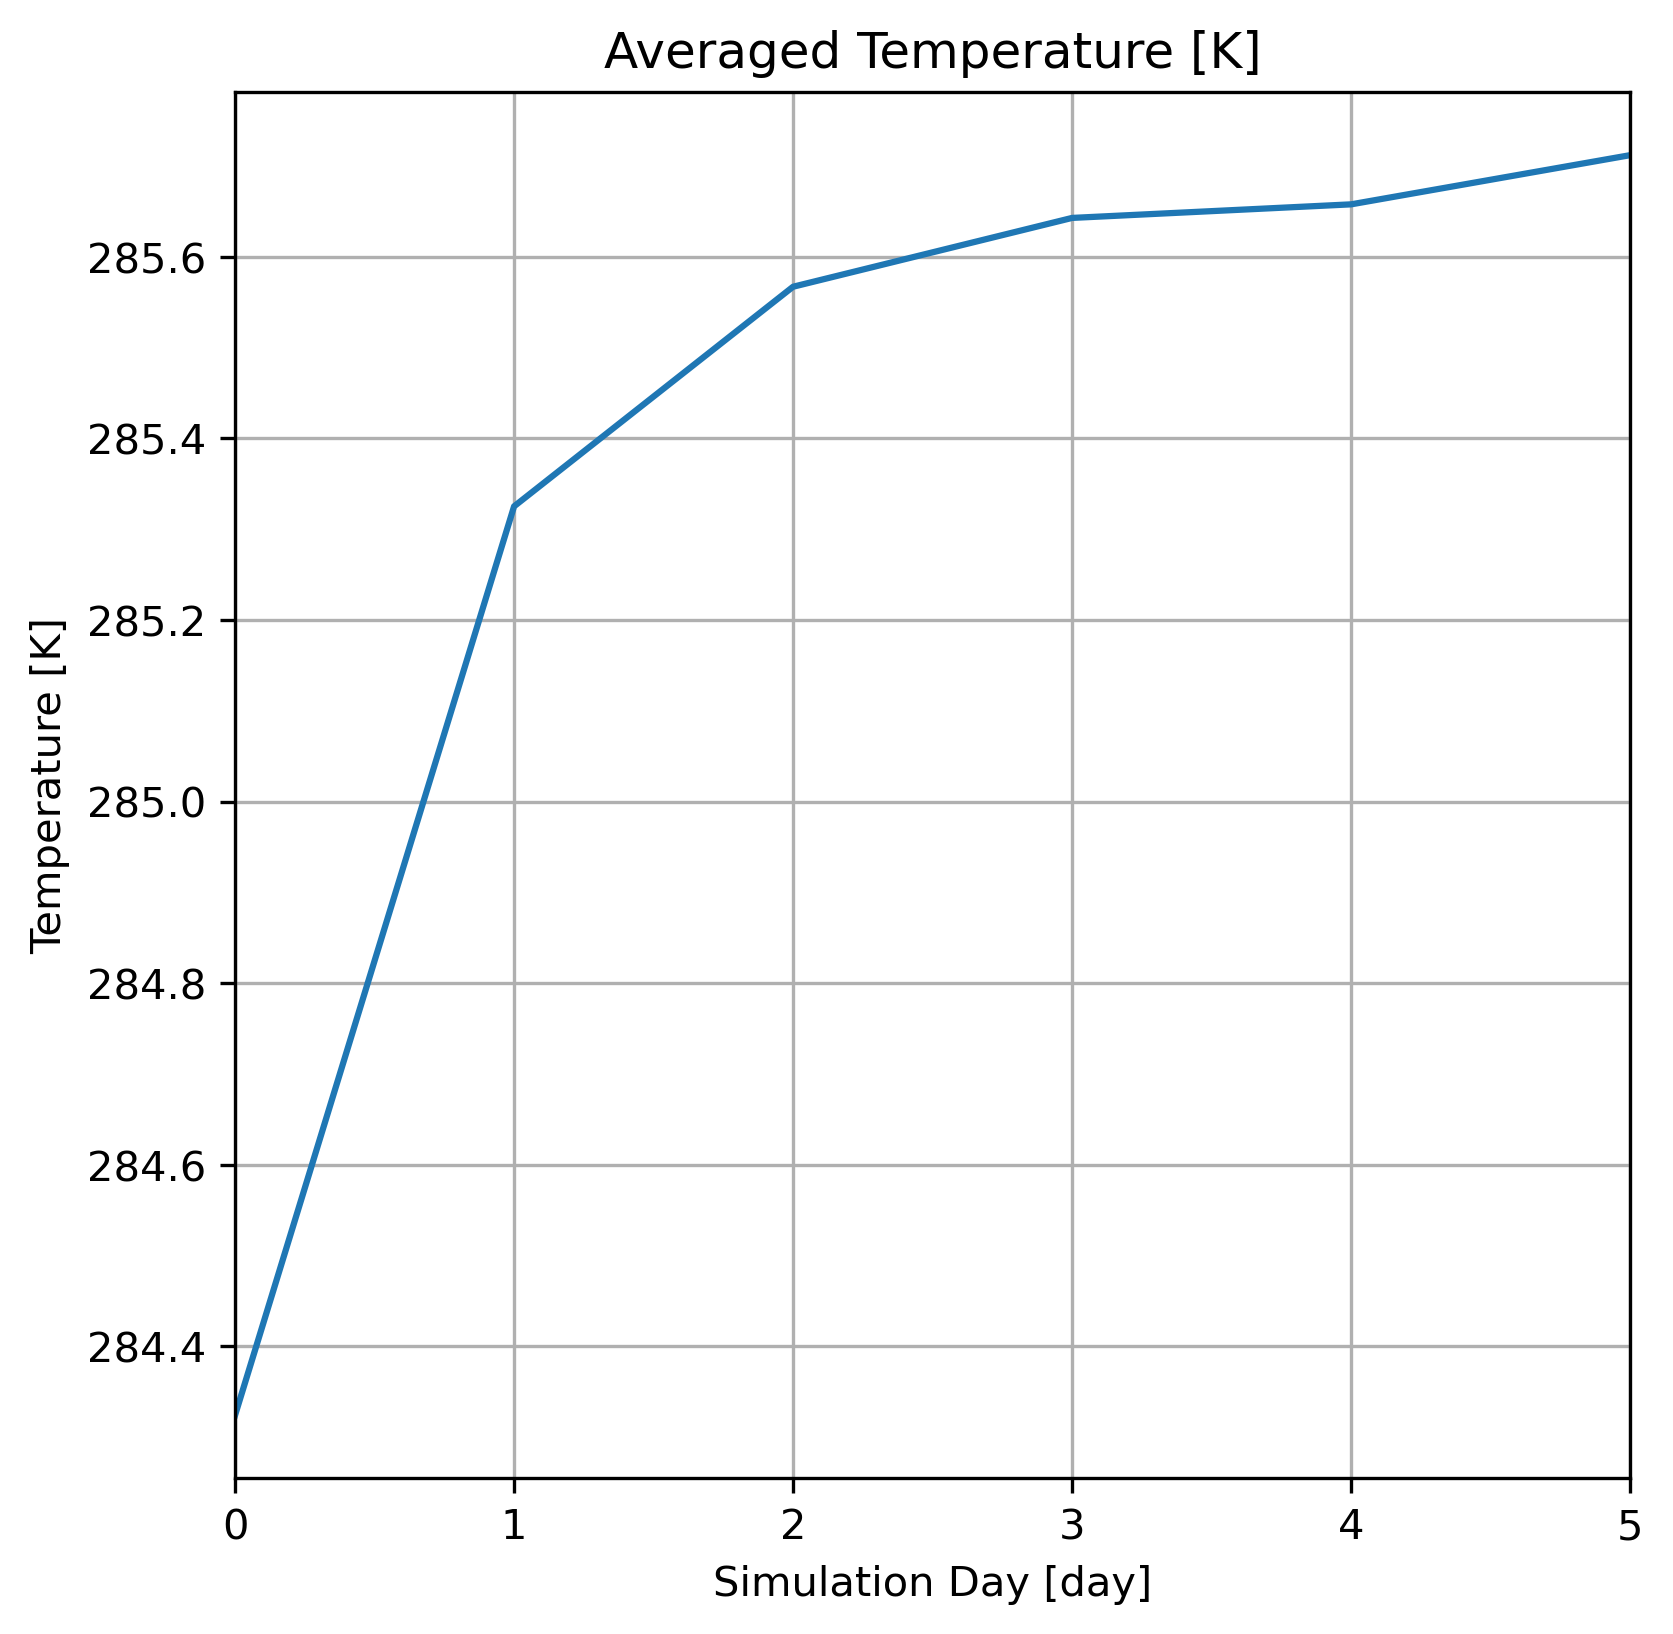

In [10]:
plt.figure(figsize=(6, 6), dpi=DPI)
plt.plot(np.asarray(Tsavg))
plt.title("Averaged Temperature [K]")
plt.xlabel("Simulation Day [day]")
plt.ylabel("Temperature [K]")
plt.xlim(0, 5)
plt.grid('--')
plt.savefig('Temperature.png', dpi=DPI)

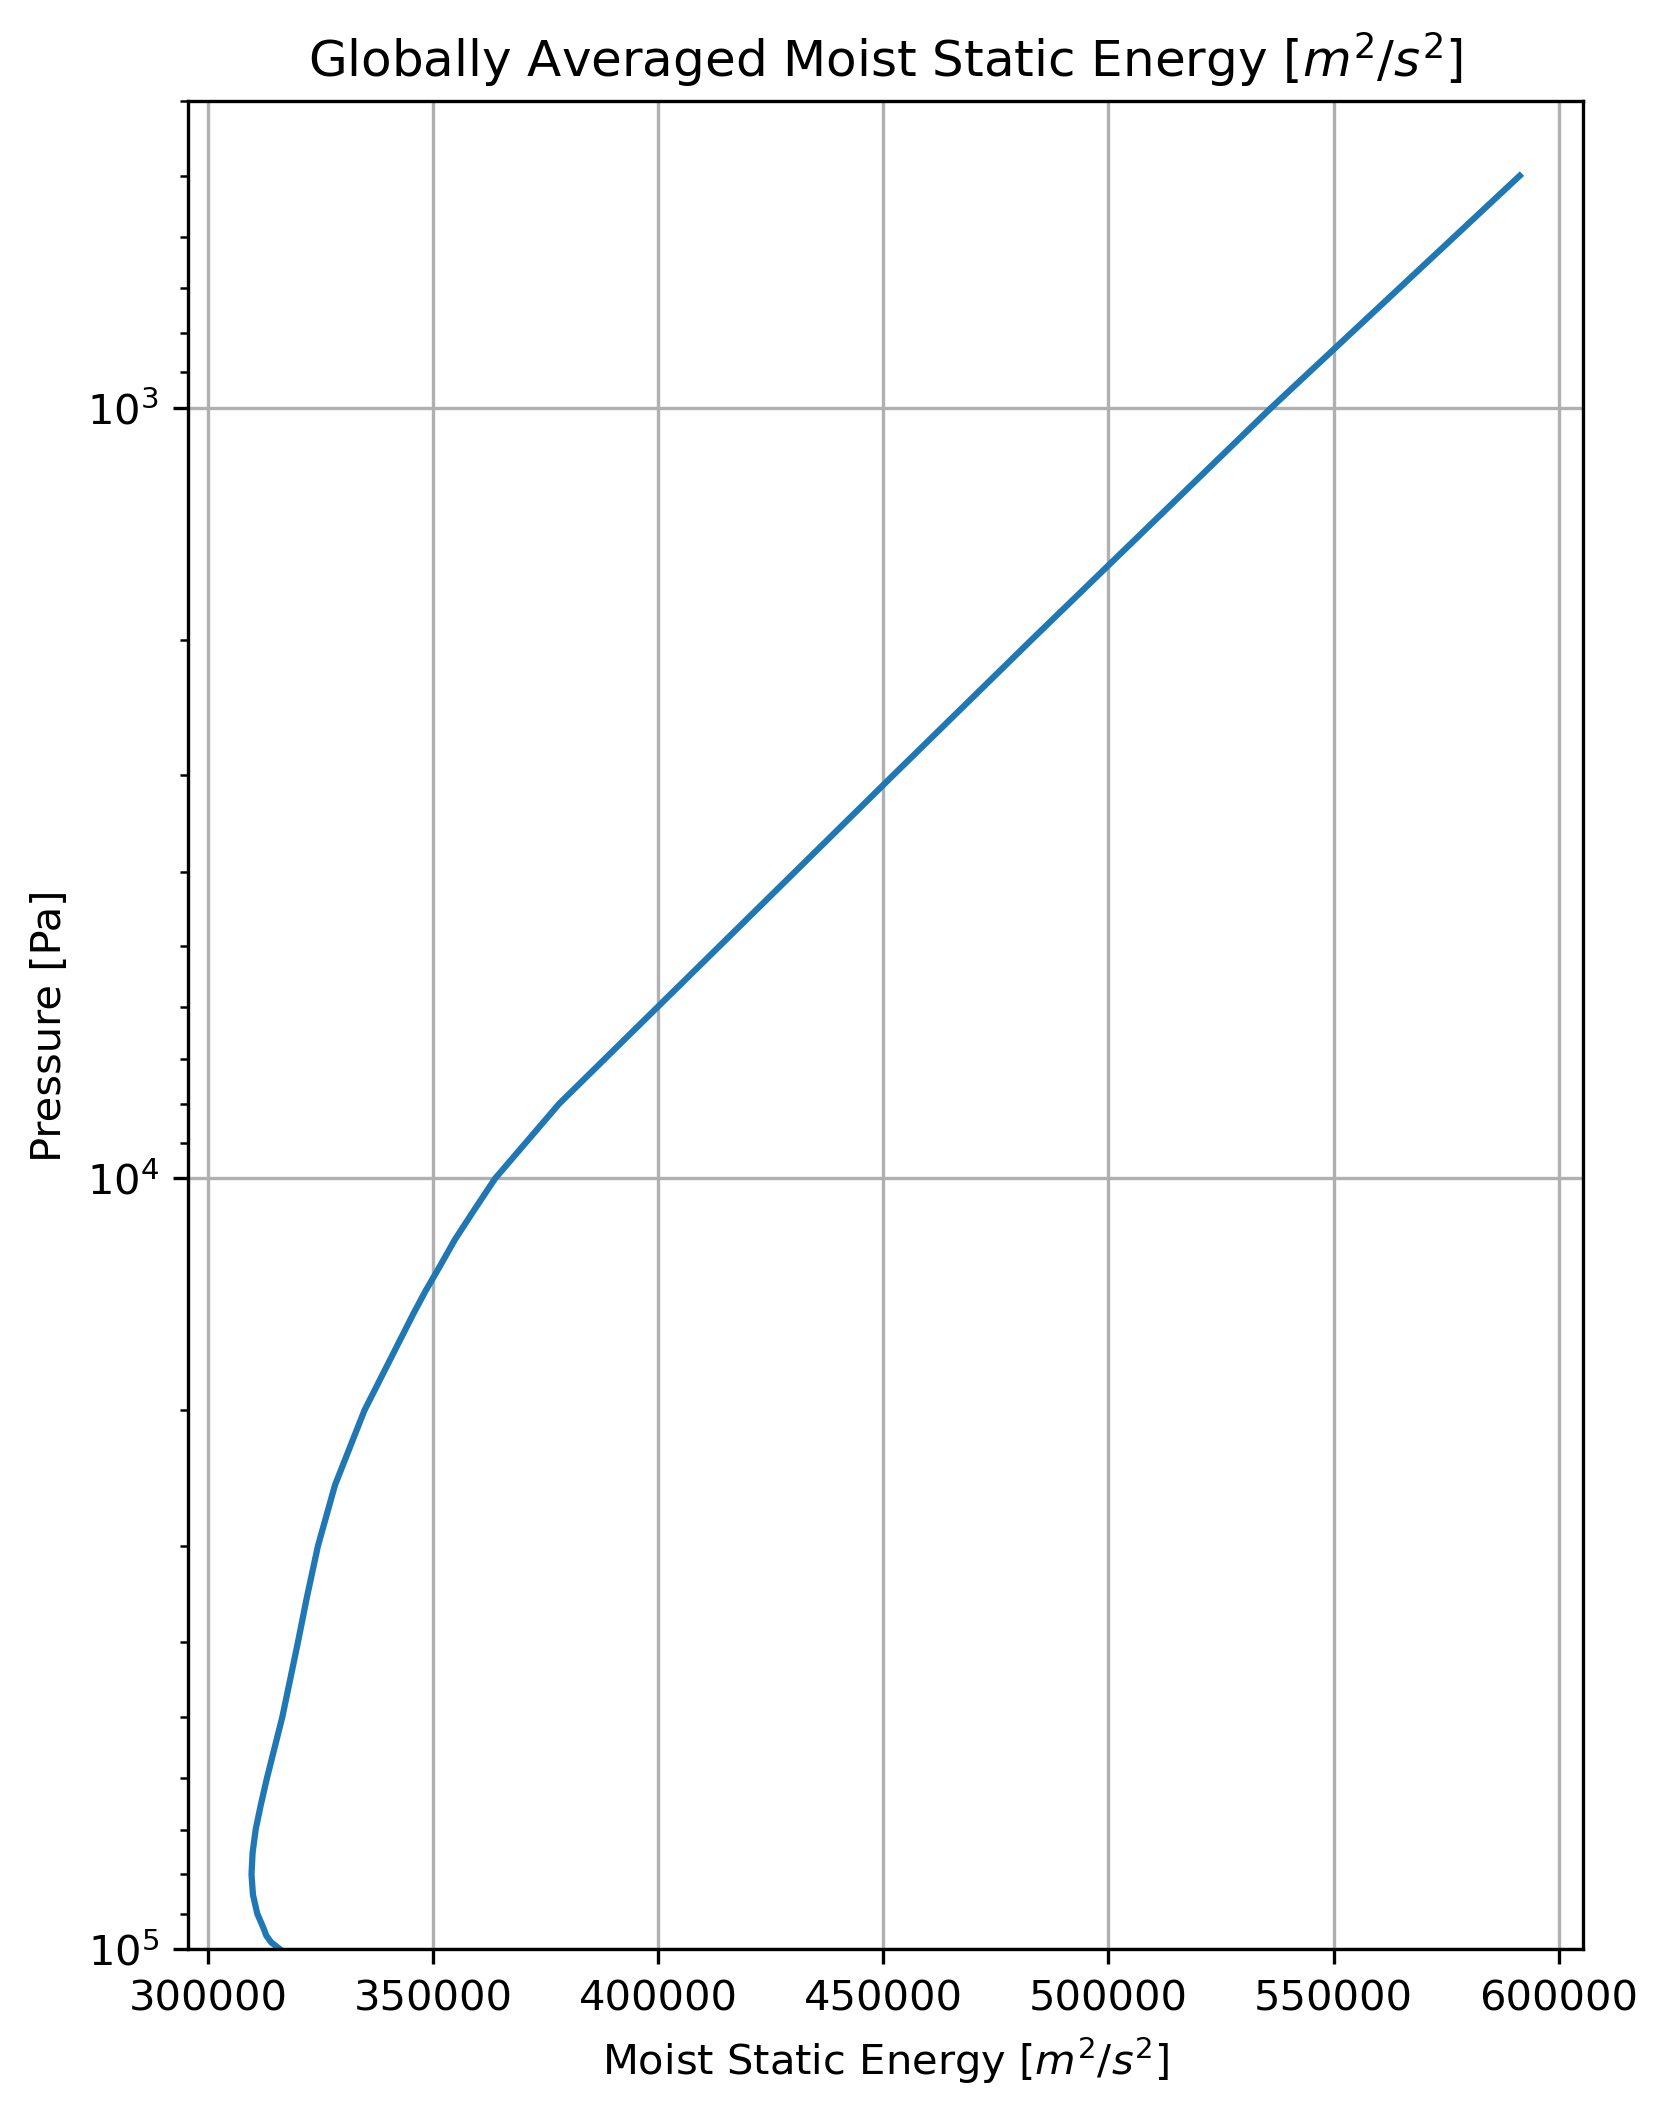

In [14]:
plt.figure(figsize=(6, 8), dpi=DPI)
plt.plot(MSE_mean, P_ip)
plt.title("Globally Averaged Moist Static Energy " + r"[$m^2/s^2$]")
plt.xlabel("Moist Static Energy " + r"[$m^2/s^2$]")
plt.ylabel("Pressure [Pa]")
plt.yscale('log')
plt.ylim(100000, 400)
plt.grid('--')
plt.savefig('MSE.png', dpi=DPI)